# Neural Network Model for Predicting Movie Feature Vectors from Neuron Responses

## Import source code and packages

In [1]:
import os
import sys
sys.path.append('./src')

import image_feature_predict_nn as ifpnn

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tfl
import torch

## Set load and save path for all data

In [2]:
load_path = './data/'
save_path = './data/'

## Load data to train and test model

In [3]:
# load .npz of response vectors
resp_dict = np.load(os.path.join(load_path,'response_vectors.npz'))
resp = resp_dict['response_vectors']
resp = np.swapaxes(resp,0,1)
print('Shape of response vector array (nSamples, nCells): ',resp.shape)

# load .npz of feature vectors
feat_dict = np.load(os.path.join(load_path,'feature_vectors.npz'))
feat = feat_dict['feature_vectors']
feat = np.swapaxes(feat,0,1)
print('Shape of feature vector array (nSamples, nFeatures): ',feat.shape)

# load transformation matrix for image reconstruction
G_dict = np.load(os.path.join(load_path,'G_transforms.npz'))
G_rev = G_dict['G_rev']

# load original images
im = tfl.imread(os.path.join(load_path,'processed_movie.tif'))
im = np.rollaxis(im,0,3) # make last dimension the frames
image_size = im[:,:,0].shape

Shape of response vector array (nSamples, nCells):  (36000, 132)
Shape of feature vector array (nSamples, nFeatures):  (36000, 1248)


## Initialize and train neural network model

In [4]:
# model training parameters
n_folds = 1
test_size = 0.2 # will only be used if n_folds == 1
n_epochs = 20
batch_size = 16
hidden_dim_list = [1000,2000]
learning_rate = None # None = uses Adam optimizer's default
dropout_p = 0

In [5]:
# initialize, train, and test model
IFP = ifpnn.ImageFeaturePredict(resp,feat)

model,test_resp,test_feat,fold_mses,test_avg_mse = IFP.train_test_network(n_folds=n_folds,
                                                                          test_size=test_size,
                                                                          n_epochs=n_epochs,
                                                                          batch_size=batch_size,
                                                                          hidden_dim_list=hidden_dim_list,
                                                                          dropout_p=dropout_p,
                                                                          learning_rate=learning_rate,
                                                                          save_path=save_path)

-----------------------
Fold  1
-----------------------
Average MSE for Epoch #1: 0.000443223637842617
Average MSE for Epoch #2: 0.0002906577440343201
Average MSE for Epoch #3: 0.00025251321659546785
Average MSE for Epoch #4: 0.00023127136033646527
Average MSE for Epoch #5: 0.0002170260331404849
Average MSE for Epoch #6: 0.0002060922369131617
Average MSE for Epoch #7: 0.00019812501312957764
Average MSE for Epoch #8: 0.00019157514178381492
Average MSE for Epoch #9: 0.00018592262537847352
Average MSE for Epoch #10: 0.00018132321289848413
Average MSE for Epoch #11: 0.0001772950141985769
Average MSE for Epoch #12: 0.00017389375710677769
Average MSE for Epoch #13: 0.00017047513695123858
Average MSE for Epoch #14: 0.0001679246567986222
Average MSE for Epoch #15: 0.0001652336981173895
Average MSE for Epoch #16: 0.00016312219955853547
Average MSE for Epoch #17: 0.0001608803810966598
Average MSE for Epoch #18: 0.00015892920171783288
Average MSE for Epoch #19: 0.00015707057921448235
Average MSE 

In [6]:
# save model (from last fold) for later use
model_save_path = os.path.join(save_path,'image_predict_model.pt')
torch.save(model.state_dict(), model_save_path)

## Calculate extra model performance criteria (image correlations) and save predicted images

In [7]:
# calculate correlations between images in test split (reconstructed vs. predicted AND original vs. predicted)
r_recon_pred_test,r_orig_pred_test = IFP.test_predicted_image_correlations(model,test_resp,test_feat,im,G_rev)

# calculate correlations between all images (reconstructed vs. predicted AND original vs. predicted)
r_recon_pred_all,r_orig_pred_all = IFP.test_predicted_image_correlations(model,resp,feat,im,G_rev)

# save entire predicted movie
pred_im = IFP.save_predicted_movie(model,resp,G_rev,image_size,save_path)

Avg Corr (r) - recon and pred:  0.9154467399343921
Avg Corr (r) - orig and pred:  0.8223675330924155
Avg Corr (r) - recon and pred:  0.9241462050518011
Avg Corr (r) - orig and pred:  0.8312494665105202


## Assess model performance
* Mean-square error across training epochs/folds
* Distribution of correlations between predicted and ground truth images
* Image frame viewer

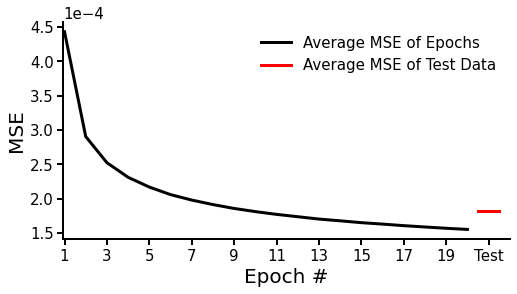

In [8]:
# plot average MSE across batches for each epoch, for each fold
ifpnn.plot_epoch_mse_folds(fold_mses,test_mses=test_avg_mse)

Avg Corr (r) - recon and pred: 0.9154467399343921


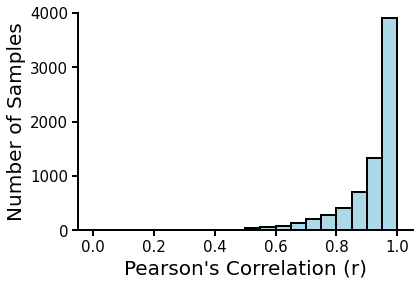

Avg Corr (r) - orig and pred: 0.8223675330924155


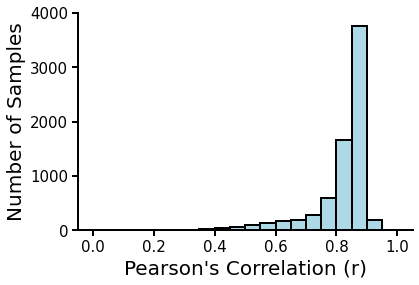

In [9]:
# plot distribution of correlations between all images from test split in last fold

color='lightblue'
yticks = [0,1000,2000,3000,4000]

print('Avg Corr (r) - recon and pred: '+str(np.mean(r_recon_pred_test)))
ifpnn.plot_correlation_hist(r_recon_pred_test,color,yticks)

print('Avg Corr (r) - orig and pred: '+str(np.mean(r_orig_pred_test)))
ifpnn.plot_correlation_hist(r_orig_pred_test,color,yticks)

Avg Corr (r) - recon and pred: 0.9241462050518011


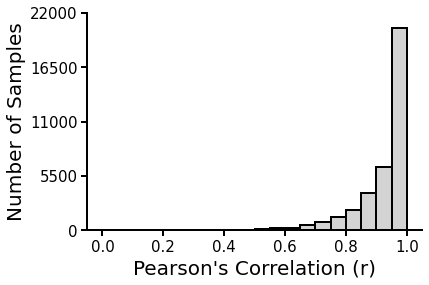

Avg Corr (r) - orig and pred: 0.8312494665105202


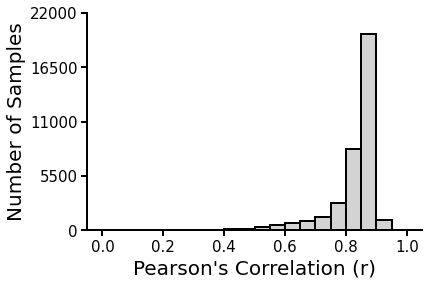

In [10]:
# plot distribution of correlations between all images

color='lightgrey'
yticks = [0,5500,11000,16500,22000]

print('Avg Corr (r) - recon and pred: '+str(np.mean(r_recon_pred_all)))
ifpnn.plot_correlation_hist(r_recon_pred_all,color,yticks)

print('Avg Corr (r) - orig and pred: '+str(np.mean(r_orig_pred_all)))
ifpnn.plot_correlation_hist(r_orig_pred_all,color,yticks)

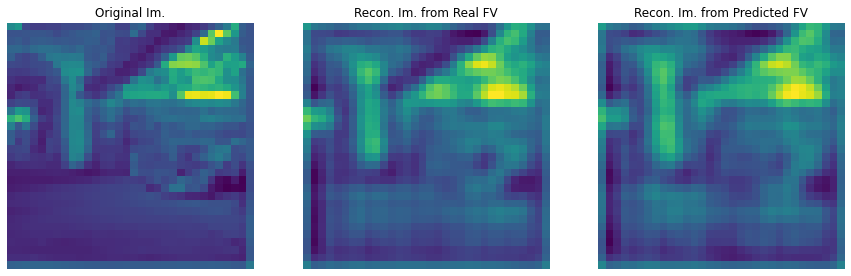

In [11]:
# plot example frames based on frame index and repetition number

iF = 190 # the frame of the movie (0-599)
rep = 30 # the repetition of the move presentation (0-59)
    
ifpnn.plot_frames_pred(im,feat,G_rev,pred_im,iF,rep)

## Generate artificial perturbations to observe effects on image perception using trained model
### Example 'perturbation' below

In [17]:
# perturbation parameters
perturb_value = 0.1 # activation value to perturb to b/w [-1,1]
perturb_frames = (180,200) # (start,end) frame of perturbation

perturb_IDs = np.random.randint(0,resp.shape[1],25)
print('Cell IDs to perturb: ',perturb_IDs)

Cell IDs to perturb:  [ 20  83  57   4  59 125 106 101  54  24  11  38  23  32  57  44  54  87
  79 131  79 121  57  99  95]


In [18]:
# generate perturbed image frames
perturb_resp,perturb_im = ifpnn.artificial_perturb_predict(im,G_rev,resp,model,
                                                           perturb_IDs,
                                                           perturb_frames,
                                                           perturb_value,
                                                           save_path)

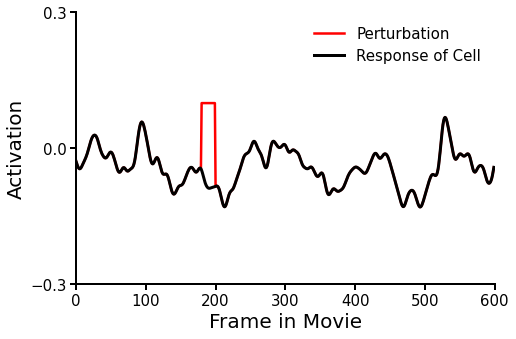

In [19]:
# plot example perturbed cell trace

example_cell_ID = perturb_IDs[2]

ifpnn.plot_artificial_perturb_trace(perturb_resp,resp,example_cell_ID)

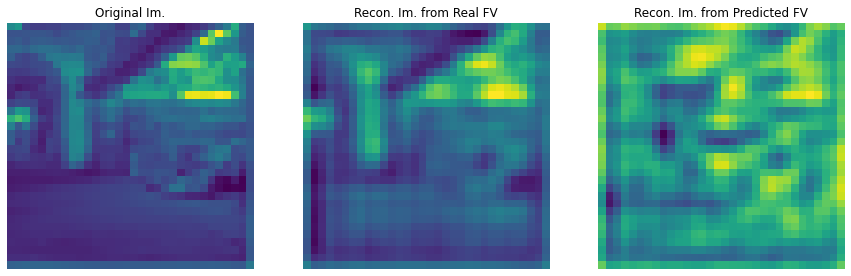

In [20]:
# plot artificially perturbed predicted frame

iF = 190 # the frame of the movie (0-599)

ifpnn.plot_frames_pred(im,feat,G_rev,perturb_im,iF)